In [1]:
print("hello world")

hello world


In [2]:
import getpass
import os

from dotenv import load_dotenv

load_dotenv()

def set_env(key: str):
  if key not in os.environ:
    os.environ[key]=getpass.getpass(f"{key}:")


In [3]:
set_env("GROQ_API_KEY")
set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="sql-llm-agent-2"

In [4]:
username = "root"
password = "jagan2911"
host = 'localhost'
database = 'jagandb'

In [5]:
from langchain_community.utilities import SQLDatabase
import pymysql

In [6]:
db = SQLDatabase.from_uri(f"mysql+pymysql://{username}:{password}@{host}/{database}",sample_rows_in_table_info = 3)
print(db.dialect)
print(db.get_usable_table_names())

mysql
['employee']


In [7]:
from langchain_community.utilities import SQLDatabase
from typing import Any
from langchain_core.runnables import RunnableWithFallbacks, RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

In [8]:
QUERY_CHECK_INSTRUCTION = """You are a SQL expert with a strong attention to detail.
Double check the SQL query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""


QUERY_GEN_INSTRUCTION = """You are a SQL expert with exceptional attention to detail. Your task is to analyze user requests, interpret SQL query results, and provide appropriate responses. Follow these instructions:

Identify Key Components: Carefully analyze the user's message to determine:

The user question.
The provided table schemas.
Any SQL query statements.
The query result or error (if applicable).
Handle Missing Queries: If no query result is available to answer the user's question:

Construct a syntactically correct SQL query to address the user question.
Do not perform any DML operations (e.g., INSERT, UPDATE, DELETE, DROP).
Respond only with the SQL query statement.
Example:
SELECT id, name FROM pets;
Handle Query Errors: If a query was executed but resulted in an error:

Respond by repeating the exact error message.
Example:
"Error: Pets table doesn't exist"
Interpret Results: If a query was executed successfully and returned results:

Interpret the results to answer the user's question.
Respond in the format: Answer: <<question answer>>
Example:
"Answer: There are three cats registered as adopted."
Instructions:
Apply these steps to handle user queries effectively. Your primary focus is to ensure correctness, clarity, and precision in your responses.
"""

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
config = {"configurable": {"thread_id": "1"}}

In [11]:
def create_tool_node_with_fallback(tools:list)-> RunnableWithFallbacks[Any,dict]:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],exception_key="error"
    )
def handle_tool_error(state)->dict:
    error=state.get("error")
    tool_calls=state["messages"][-1].tool_calls
    return {
        "messages":[ToolMessage(
            content=f"Error:{repr(error)}\n Fix your code and try again. ",
            tool_call_id=tc["id"],
        )
         for tc in tool_calls          
        ]
    }   

In [12]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

In [13]:
toolkit= SQLDatabaseToolkit(db=db, llm=ChatGroq(model="llama-3.3-70b-specdec"))
tools= toolkit.get_tools()

In [14]:
toolkit= SQLDatabaseToolkit(db=db, llm=ChatGroq(model="llama-3.3-70b-specdec"))
tools= toolkit.get_tools()
list_tables_tool=next(tool for tool in tools if tool.name=="sql_db_list_tables")    
get_schema_tool=next(tool for tool in tools if tool.name=="sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("employee"))

employee

CREATE TABLE employee (
	`EmployeeID` INTEGER NOT NULL, 
	`EmployeeName` VARCHAR(255) NOT NULL, 
	`DateOfJoining` DATE NOT NULL, 
	`EmployeeType` VARCHAR(255), 
	`PayTier` VARCHAR(255), 
	PRIMARY KEY (`EmployeeID`)
)ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE utf8mb4_0900_ai_ci

/*
3 rows from employee table:
EmployeeID	EmployeeName	DateOfJoining	EmployeeType	PayTier
1	John Doe	2023-01-15	Manager	Tier 1
2	Jane Smith	2022-06-01	Engineer-1	Tier 3
3	Alice Johnson	2021-09-12	Tester	Tier 4
*/


In [15]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [16]:
from langchain_core.tools import tool

@tool
def db_query_tool(query:str)->str:
    """Executes an sql query against the database and gets back 
    the result. If query is not correct an error message is returned.

    Args:
        query (str): A valid sql query string

    Returns:
        str: The result of the query if present or an error message
    """
    try:
        result=db.run_no_throw(query)
        if not result:
            return "Error: Query failed to return anything. Try again."
        return result
    except Exception as e:
        return f"Error: {str(e)}. Please check your query again."

In [17]:
print(db_query_tool.invoke("SELECT * FROM employee"))
print(db_query_tool.invoke("SELECT * FROM employeeee"))
print(db_query_tool.invoke("SELECT * FROM employee where PayTier = 100"))

[(1, 'John Doe', datetime.date(2023, 1, 15), 'Manager', 'Tier 1'), (2, 'Jane Smith', datetime.date(2022, 6, 1), 'Engineer-1', 'Tier 3'), (3, 'Alice Johnson', datetime.date(2021, 9, 12), 'Tester', 'Tier 4'), (4, 'Bob Brown', datetime.date(2020, 3, 23), 'Engineer-2', 'Tier 2'), (5, 'Charlie Davis', datetime.date(2023, 7, 8), 'Team Lead', 'Tier 1'), (6, 'Eve Martin', datetime.date(2019, 11, 5), 'Engineer-1', 'Tier 3'), (7, 'Frank White', datetime.date(2022, 2, 17), 'Tester', 'Tier 4'), (8, 'Grace Green', datetime.date(2021, 8, 30), 'Manager', 'Tier 1'), (9, 'Hank Lee', datetime.date(2020, 12, 19), 'Engineer-2', 'Tier 2'), (10, 'Ivy Wilson', datetime.date(2023, 3, 11), 'Team Lead', 'Tier 1'), (11, 'Jack Black', datetime.date(2022, 5, 25), 'Engineer-1', 'Tier 3'), (12, 'Karen Scott', datetime.date(2021, 7, 14), 'Tester', 'Tier 4'), (13, 'Larry Adams', datetime.date(2020, 9, 1), 'Engineer-2', 'Tier 2'), (14, 'Mona Young', datetime.date(2019, 4, 22), 'Manager', 'Tier 1'), (15, 'Nate King', da

In [18]:
query_check_prompt=ChatPromptTemplate.from_messages([("system",QUERY_CHECK_INSTRUCTION),("placeholder","{messages}")])

In [19]:
query_check_prompt.pretty_print()

================================ System Message ================================

You are a SQL expert with a strong attention to detail.
Double check the SQL query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.

============================= Messages Placeholder =============================

{messages}


In [20]:
query_checker=query_check_prompt | ChatGroq(model="llama-3.3-70b-specdec",temperature=0).bind_tools([db_query_tool],tool_choice="required")


In [21]:
query_gen_prompt=ChatPromptTemplate.from_messages([("system",QUERY_GEN_INSTRUCTION),("placeholder","{messages}")])
query_gen_chain=query_gen_prompt | ChatGroq(model="llama-3.3-70b-specdec")


In [22]:
query_gen_prompt.pretty_print()

================================ System Message ================================

You are a SQL expert with exceptional attention to detail. Your task is to analyze user requests, interpret SQL query results, and provide appropriate responses. Follow these instructions:

Identify Key Components: Carefully analyze the user's message to determine:

The user question.
The provided table schemas.
Any SQL query statements.
The query result or error (if applicable).
Handle Missing Queries: If no query result is available to answer the user's question:

Construct a syntactically correct SQL query to address the user question.
Do not perform any DML operations (e.g., INSERT, UPDATE, DELETE, DROP).
Respond only with the SQL query statement.
Example:
SELECT id, name FROM pets;
Handle Query Errors: If a query was executed but resulted in an error:

Respond by repeating the exact error message.
Example:
"Error: Pets table doesn't exist"
Interpret Results: If a query was executed successfully and r

In [23]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage,HumanMessage,RemoveMessage
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph, MessagesState

In [24]:
class State(MessagesState):
    pass

In [25]:
list_tables = create_tool_node_with_fallback([list_tables_tool])

get_schema_tool_with_fallback = create_tool_node_with_fallback([get_schema_tool])

execute_query = create_tool_node_with_fallback([db_query_tool])


In [26]:
def first_tool_call(state:State) ->dict[str,list[AIMessage]]:
    tool_call={"name":"sql_db_list_tables",
               "args":{},
               "id":"tool_abcd123"}
    return {"messages":[AIMessage(
        content='',
        tool_calls=[tool_call])]}


In [28]:
def model_check_query(state:State)->dict[str,list[AIMessage]]:
    return {"messages": [query_checker.invoke({"messages": [state["messages"][-1]]},config)]}



In [27]:
def model_get_schema(state:State):
    model_get_schema=ChatGroq(model="llama-3.3-70b-specdec",temperature=0).bind_tools([get_schema_tool])
    return {
        "messages":[model_get_schema.invoke(state["messages"],config)]
    }
def query_gen_node(state:State):
    message=query_gen_chain.invoke(state)
    return {"messages":[message]}

In [29]:
def should_continue(state:State)-> Literal[END,"correct_query","query_gen"]:
    messages=state["messages"]
    last_message=messages[-1]
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [30]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

In [31]:
builder=StateGraph(State)
builder.add_node("first_tool_call",first_tool_call)
builder.add_node("list_tables",list_tables)
builder.add_node("get_schema_tool",get_schema_tool_with_fallback)
builder.add_node("model_get_schema",model_get_schema)
builder.add_node("query_gen",query_gen_node)
builder.add_node("correct_query",model_check_query)
builder.add_node("execute_query",execute_query)


In [32]:
builder.add_edge(START, "first_tool_call")
builder.add_edge("first_tool_call", "list_tables")
builder.add_edge("list_tables", "model_get_schema")
builder.add_edge("model_get_schema", "get_schema_tool")
builder.add_edge("get_schema_tool", "query_gen")
builder.add_conditional_edges("query_gen", should_continue)
builder.add_edge("correct_query", "execute_query")
builder.add_edge("execute_query", "query_gen")


In [33]:
graph=builder.compile()
react_graph_memory = builder.compile(checkpointer=memory)

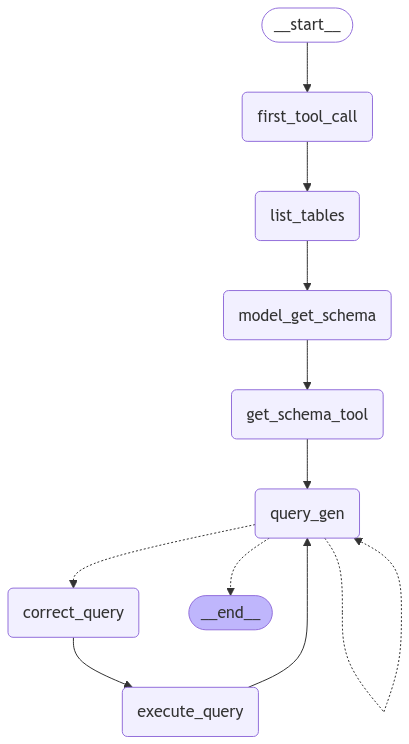

In [68]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [69]:
for event in graph.stream(
    {"messages": [("user", "How many tier 1 employees are present?")]}
):
    print(f"{event}\n\n")

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='17142afc-207e-4aa6-9e5b-3254686d25c3', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}


{'list_tables': {'messages': [ToolMessage(content='employee', name='sql_db_list_tables', id='ca2367f0-871d-4579-b3ba-f5419bbf743d', tool_call_id='tool_abcd123')]}}


{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_w5k1', 'function': {'arguments': '{"table_names": "employee"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 365, 'total_tokens': 382, 'completion_time': 0.011973966, 'prompt_time': 0.044182634, 'queue_time': 0.054200002, 'total_time': 0.0561566}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_74379b522c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f216586-55ba-4ce

In [38]:
event["query_gen"]["messages"][-1].content

'Answer: There are 20 tier 1 employees present.'

In [72]:
for event in graph.stream(
    {"messages": [("user", "From those what is the most common job role?")]}
):
    print(f"{event}\n\n")

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='75fcfd1f-a5de-49ed-be40-606ae3c3492f', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}


{'list_tables': {'messages': [ToolMessage(content='employee', name='sql_db_list_tables', id='0b7853ee-a851-40b2-a72d-9edaffcf24db', tool_call_id='tool_abcd123')]}}


{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dch7', 'function': {'arguments': '{"table_names": "employee"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 366, 'total_tokens': 383, 'completion_time': 0.010361608, 'prompt_time': 0.044234813, 'queue_time': 0.054328213, 'total_time': 0.054596421}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_74379b522c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-af7d72cc-d4c1-4

In [84]:
messages=graph.invoke(
    {"messages": [("user", "what are they?")]}
)

In [85]:
messages["messages"][-1].content

'Answer: There are 50 employees in the employee table.'